In [44]:
import os
import sys
from typing import Tuple

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame
import sqlite3

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import settings

# UTILS

## Dict

In [45]:
# Abreviatures extracted from https://laligafv.foroactivo.com/t5325-abreviaturas-de-los-equipos
team_names_3 = {
    "Alavés": "ALA",
    "Athletic": "ATH",
    "Atlético Madrid": "ATM",
    "Barcelona": "BAR",
    "CA Osasuna": "OSA",
    "Celta de Vigo": "CEL",
    "Cádiz CF": "CAD",
    "Elche CF": "ELC",
    "Getafe": "GET",
    "Granada CF": "GRA",
    "Levante": "LEV",
    "Real Betis": "BET",
    "Real Madrid": "RMA",
    "Real Sociedad": "RSO",
    "Real Valladolid": "VLL",
    "SD Eibar": "EIB",
    "SD Huesca": "HUE",
    "Sevilla FC": "SEV",
    "Valencia": "VAL",
    "Villarreal": "VIL",
    "FC Andorra": "FCA",
    "CF Badalona": "BDN",
    "CD Castellón": "CAS",
    "SD Eibar": "EIB",
    "Getafe FC": "GET",
    "Girona FC": "GIR",
    "Granada CF": "GRA",
    "Racing de Ferrol": "FER",
    "Racing de Santander": "RAC",
    "Rayo Vallecano": "RAY",
    "UP de Langreo": "UPL",
    "AD Alcorcón": "ALC",
    "Celta de Vigo": "CEL",
    "Deportivo Alavés": "ALA",
    "SD Huesca": "HUE",
    "UD Las Palmas": "LAS",
    "CD Leganés": "LEG",
    "Málaga CF": "MAL",
    "CA Osasuna": "OSA",
    "Real Avilés_CF": "RAI",
    "Real Jaén CF": "JAE",
    "Recreativo de Huelva": "REC",
    "Sporting de Gijón": "SPO",
    "Real Zaragoza": "ZAR",
    "UD Almeria": "ALM",
    "UD Almería": "ALM",
    "CD Badajoz": "BAD",
    "AD Ceuta": "CEU",
    "SD Compostela": "COM",
    "Dep. La Coruña": "DEP",
    "RCD Espanyol": "ESP",
    "Espanyol": "ESP",
    "Español": "ESP",
    "RCD Mallorca": "MLL",
    "SD Ponferradina": "SDP",
    "Real Betis": "BET",
    "Real Murcia CF": "MUR",
    "Real Oviedo": "OVI",
    "Real Sociedad": "RSO",
    "Real Valladolid": "VLL",
    "UE Sant Andreu": "SAN",
    "CD Tenerife": "TEN",
}

## Functions

In [46]:
def filter_season(df: DataFrame, season: str) -> DataFrame:
    """
    Filters and returns the matches within a specified season.

    :param df: DataFrame containing match data.
    :param season: Season where values will be extracted

    :return: DataFrame containing the matches within the specified season.
    """

    return df.loc[df["season"] == season]


def extract_season_values(
    df: DataFrame, season: str,
) -> Tuple[DataFrame, DataFrame]:
    """
    Extracts and returns the counts of matches per weekday and per time within a specified season.

    :param df: DataFrame containing match data.
    :param season: Season where values will be extracted
    :param column: The column name to be used for extracting time values.

    :return: A tuple containing two DataFrames:
        - df_weekday: DataFrame with counts of matches per weekday.
        - df_time: DataFrame with counts of matches per time.
    """
    df_season = filter_season(df, season)

    df_weekday = df_season["date"].dt.day_name().value_counts().reset_index()
    df_weekday.columns = ["weekday", "count"]

    df_time = df_season["time"].value_counts().reset_index()
    df_time.columns = ["time", "count"]
    return df_weekday, df_time

In [47]:
def won_games(df, team: str):
    """
    Returns those winning games for a given team

    :param df: DataFrame containing match data.
    :param team: The name of the team for which to filter the winning games.
    :return: DataFrame containing the winning games for the specified team.
    """
    home_wins = (df["home_team"] == team) & (df["home_win"] == 1)
    away_wins = (df["away_team"] == team) & (df["away_win"] == 1)
    return df[home_wins | away_wins]

def count_team_wins(df: DataFrame, team: str) -> int:
    """
    Count the number of wins for a specified team in a given DataFrame.
    """
    return won_games(df, team).shape[0]

def count_team_goals(df: DataFrame, team: str) -> int:
    """
    Count the total number of goals scored by a specific team.

    :param df: The DataFrame containing match data.
    :type df: pd.DataFrame
    :param team: The name of the team for which to count the goals.
    :type team: str
    :return: The total number of goals scored by the team.
    :rtype: int
    """
    home_goals = df[df["home_team"] == team]
    away_goals = df[df["away_team"] == team]
    return home_goals["home_score"].sum() + away_goals["away_score"].sum()

# LOAD DATA

In [48]:
with sqlite3.connect(settings.DATABASE_PATH) as conn:
    df = pd.read_sql(
        f"""
            SELECT * FROM Matches
        """,
        conn,
    )

## Pretreatment

Date is provided as mm/dd/YY as there two centuries (1900/2000) the format mm/dd/YYYY will be used to more clear.

In [49]:
def adjust_date(row):
    """
    Adjust the date by adding the correct century based on the season.
    If the date"s year is less than the season"s end year, use the start year,
    otherwise use the end year of the season.

    :param row: A row from the DataFrame containing "date" and "season".
    :return: Adjusted date string in the format DD/MM/YYYY.
    """
    start_year = int(row["season"].split("-")[0])
    end_year = int(row["season"].split("-")[1])
    date_year = int(row["date"].split("/")[-1])

    if date_year == start_year % 100:
        return row["date"][:-2] + str(start_year)
    else:
        return row["date"][:-2] + str(end_year)


df["date"] = df.apply(adjust_date, axis=1)
df = df.dropna(subset=["date"])
df["date"] = pd.to_datetime(df["date"], format="%m/%d/%Y")

df = df.dropna(subset=["score"])

Creation of util columns that will be used commonly. 

In [50]:
df["home_score"] = df["score"].str.split(":").str[0].astype(int)
df["away_score"] = df["score"].str.split(":").str[1].astype(int)

In [51]:
df["home_win"] = (df["home_score"] > df["away_score"]).astype(int)
df["away_win"] = (df["home_score"] < df["away_score"]).astype(int)
df["tie"] = (df["home_score"] == df["away_score"]).astype(int)

## EX 1

Is it true that the home team is more likely to win? Make a pie chart showing the result distribution (whether home team wins, visitor team wins, or
there’s a tie) of all matches in the data. Write in the plot the percentage of
each category.

In [52]:
home_wins = df["home_win"].sum()
away_wins = df["away_win"].sum()
ties = df["tie"].sum()

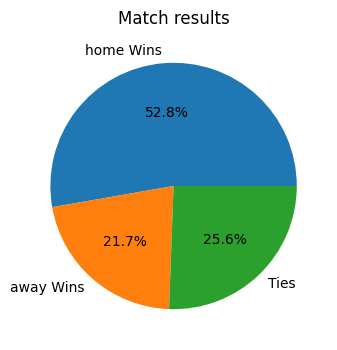

In [53]:
labels = ["home Wins", "away Wins", "Ties"]
sizes = [home_wins, away_wins, ties]

plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct="%1.1f%%")

plt.title("Match results")
plt.show()

# Ex2

What are the top ten scoring teams of all time? What are the ten teams
that concede the most? Make two bar plot charts showing each of them.
Consider only matches played in 1st division.
What have been the biggest wins? Of course, when we say biggest we mean
those with the highest goal difference. Show the top ten of them in a table.

In [54]:
df_1 = df.loc[df["division"] == 1].copy()

In [55]:
scored_goals = (
    df_1.groupby("home_team")["home_score"].sum()
    + df_1.groupby("away_team")["away_score"].sum()
).sort_values(ascending=False)
#rename column to "Teams"
scored_goals = scored_goals.rename_axis("Team")

top_10_scored = scored_goals[:10]

print(f"Teams with more goals scored are: \n{top_10_scored}")

Teams with more goals scored are: 
Team
Barcelona          6267
Real Madrid        6249
Athletic           4802
Valencia           4615
Atlético Madrid    4184
Sevilla FC         3903
Espanyol           3720
Real Sociedad      3200
Real Zaragoza      2683
Celta de Vigo      2483
dtype: int32


In [56]:
conceded_goals = (
    df_1.groupby("home_team")["away_score"].sum()
    + df_1.groupby("away_team")["home_score"].sum()
).sort_values(ascending=False)

conceded_goals = conceded_goals.rename_axis("Team")
top_10_conceded = conceded_goals[:10]

print(f"Teams with more goals conceded are: \n{top_10_conceded}")

Teams with more goals conceded are: 
Team
Espanyol           4034
Athletic           3875
Valencia           3649
Sevilla FC         3546
Real Madrid        3287
Barcelona          3259
Real Sociedad      3126
Atlético Madrid    2894
Celta de Vigo      2856
Real Zaragoza      2847
dtype: int32


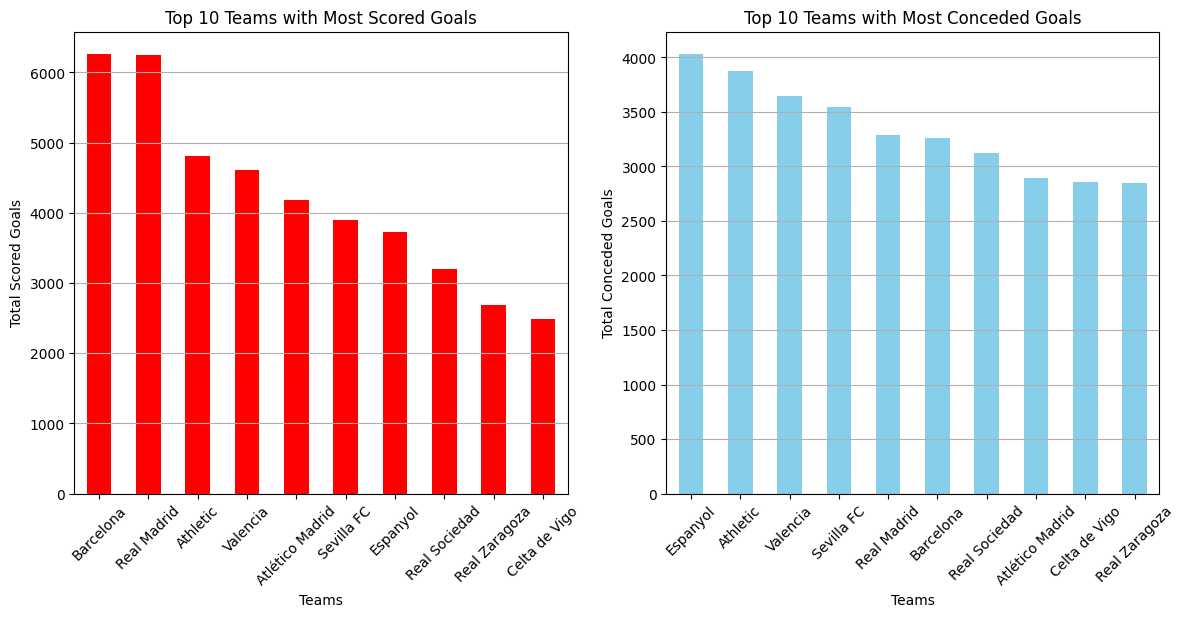

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

top_10_scored.plot(kind="bar", color="red", ax=axs[0])
axs[0].set_title("Top 10 Teams with Most Scored Goals")
axs[0].set_xlabel("Teams")
axs[0].set_ylabel("Total Scored Goals")
axs[0].set_xticklabels(top_10_scored.index, rotation=45)
axs[0].grid(axis="y")

top_10_conceded.plot(kind="bar", color="skyblue", ax=axs[1])
axs[1].set_title("Top 10 Teams with Most Conceded Goals")
axs[1].set_xlabel("Teams")
axs[1].set_ylabel("Total Conceded Goals")
axs[1].set_xticklabels(top_10_conceded.index, rotation=45)
axs[1].grid(axis="y")

In [ ]:
df_1["difference_score"] = df_1["home_score"] - df_1["away_score"]
df_1["abs_difference_score"] = df_1["difference_score"].abs()
df_high_diff = df_1.sort_values("abs_difference_score", ascending=False).head(10)[
    ["home_team", "away_team", "score"]
].reset_index(drop=True)
print(
    f"Matches with the highest absolute difference in goals: \n{df_high_diff}"
)

Matches with the highest absolute difference in goals: 
         home_team       away_team score
0         Athletic       Barcelona  12:1
1       Sevilla FC       Barcelona  11:1
2         Athletic          Lérida  10:0
3         Athletic   Celta de Vigo  10:0
4       Sevilla FC     Real Oviedo  10:0
5        Barcelona     Real Oviedo   9:0
6        Barcelona  Rayo Vallecano   9:0
7           Racing          Alavés   9:0
8      Real Madrid        Elche CF  11:2
9  Atlético Madrid     Hércules CF   9:0


# EX3

There has been a lot of discussion about how LaLiga’s television rights have
changed game schedules in the last years. Make a bar plot chart showing
the number of matches played each weekday, and make also a histogram
of match time. Compare this two graphics between seasons 2000-2001 and
2020-2021.

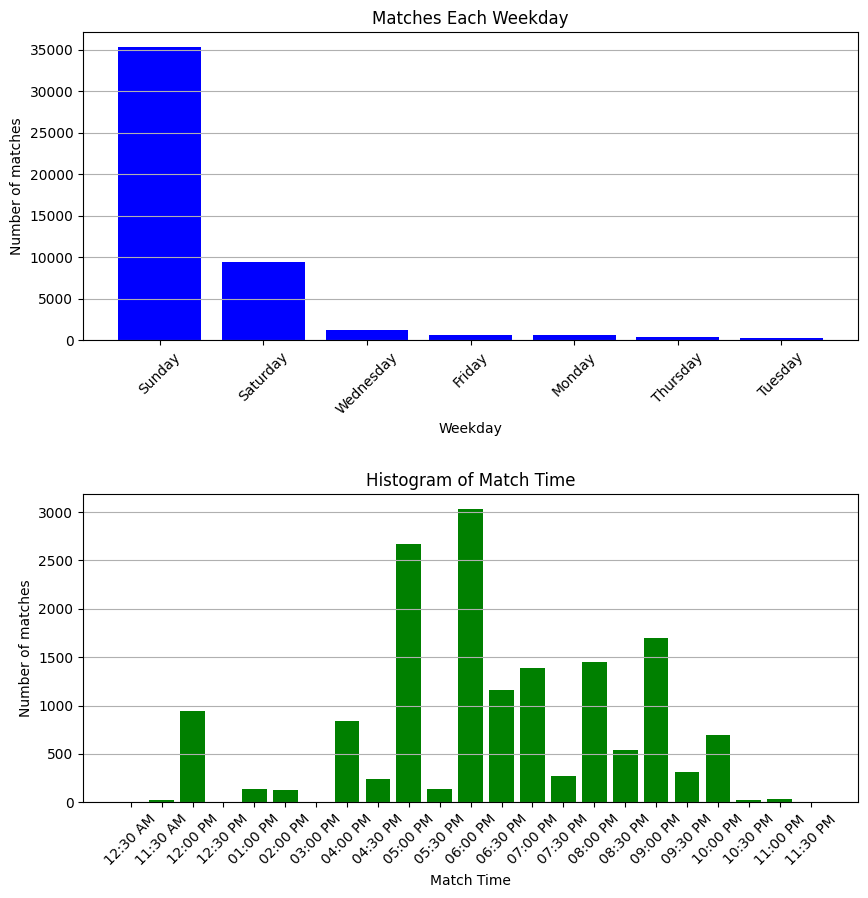

In [64]:
df_weekday = df["date"].dt.day_name().value_counts()
df_time = df["time"].value_counts()

df_weekday = df_weekday.reset_index()
df_weekday.columns = ["weekday", "count"]

df_time = df_time.reset_index()
df_time.columns = ["time", "count"]


def round_down_minutes(dt):
    """
    Rounds down the minutes of a datetime object to the nearest half hour.

    :param dt: A datetime object.
    :return: A datetime object with the minutes rounded down to the nearest half hour.
    """
    if dt.minute in [0, 29]:
        return dt.replace(minute=0)
    else:
        return dt.replace(minute=30)


df_time["time"] = pd.to_datetime(df_time["time"], format="%I:%M %p")
df_time["time"] = df_time["time"].apply(round_down_minutes)

df_time = df_time.sort_values(by="time")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

axes[0].bar(df_weekday["weekday"], df_weekday["count"], color="blue")
axes[0].set_title("Matches Each Weekday")
axes[0].set_xlabel("Weekday")
axes[0].set_ylabel("Number of matches")
axes[0].set_xticks(range(len(df_weekday["weekday"])))
axes[0].set_xticklabels(df_weekday["weekday"], rotation=45)
axes[0].grid(axis="y")

axes[1].bar(df_time["time"].dt.strftime("%I:%M %p"), df_time["count"], color="green")
axes[1].set_title("Histogram of Match Time")
axes[1].set_xlabel("Match Time")
axes[1].set_ylabel("Number of matches")
axes[1].tick_params(axis="x", rotation=45)
axes[1].grid(axis="y")

plt.subplots_adjust(hspace=0.5)

plt.show()

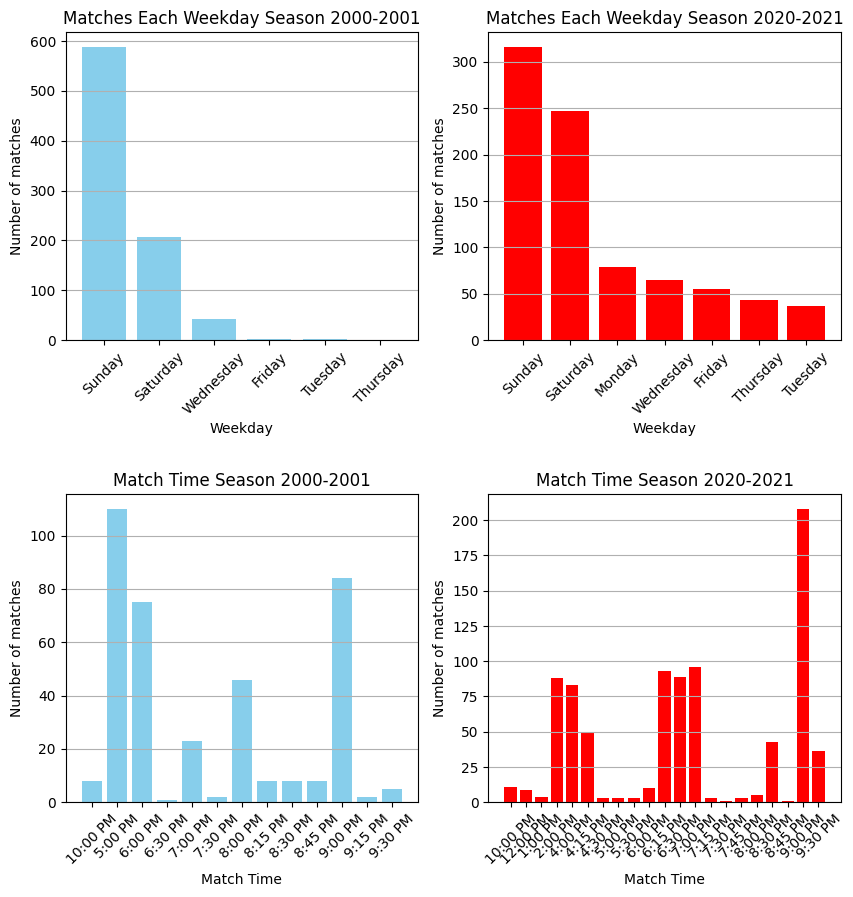

In [65]:
df_weekday_2000, df_time_2000 = extract_season_values(df, "2000-2001")
df_weekday_2020, df_time_2020 = extract_season_values(df, "2020-2021")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

axes[0][0].bar(df_weekday_2000["weekday"], df_weekday_2000["count"], color="skyblue")
axes[0][0].set_title("Matches Each Weekday Season 2000-2001")
axes[0][0].set_xlabel("Weekday")
axes[0][0].set_ylabel("Number of matches")
axes[0][0].set_xticks(range(len(df_weekday_2000["weekday"])))
axes[0][0].set_xticklabels(df_weekday_2000["weekday"], rotation=45)
axes[0][0].grid(axis="y")

axes[0][1].bar(df_weekday_2020["weekday"], df_weekday_2020["count"], color="red")
axes[0][1].set_title("Matches Each Weekday Season 2020-2021")
axes[0][1].set_xlabel("Weekday")
axes[0][1].set_ylabel("Number of matches")
axes[0][1].set_xticks(range(len(df_weekday_2020["weekday"])))
axes[0][1].set_xticklabels(df_weekday_2020["weekday"], rotation=45)
axes[0][1].grid(axis="y")


df_time_2000 = df_time_2000.sort_values(by="time")
df_time_2020 = df_time_2020.sort_values(by="time")


axes[1][0].bar(df_time_2000["time"], df_time_2000["count"], color="skyblue")
axes[1][0].set_title("Match Time Season 2000-2001")
axes[1][0].set_xlabel("Match Time")
axes[1][0].set_ylabel("Number of matches")
axes[1][0].tick_params(axis="x", rotation=45)
axes[1][0].grid(axis="y")

axes[1][1].bar(df_time_2020["time"], df_time_2020["count"], color="red")
axes[1][1].set_title("Match Time Season 2020-2021")
axes[1][1].set_xlabel("Match Time")
axes[1][1].set_ylabel("Number of matches")
axes[1][1].tick_params(axis="x", rotation=45)
axes[1][1].grid(axis="y")

plt.subplots_adjust(hspace=0.5)

plt.show()

# EX4

Build a cross results table for season 2020-2021 (1st division). Figure 1 is an
example taken from Wikipedia. Try to make it the most similar to this one,
painting the background of each cell according to result (green in case local
team wins and red in case visitor team wins). Also, could you model the
intensity of this background color with the goal difference from the match?

Write a function that, given the season and division, plots the cross results table. Function prototype should be like plot_cross_results_ta-
ble(season, division) and return the plot object.

In [66]:
def highlight_wins(val):
    """
    Highlight the maximum value in a Series with a green background.

    :param val: A value in a DataFrame.
    :return: A string with CSS properties to highlight the maximum value.
    """
    if isinstance(val, str):
        val = int(val.split(":")[0]) - int(val.split(":")[1])
    if val > 0:
        intensity = min(val / 10, 1)
        return f"background-color: rgba(0, 255, 0, {intensity})"
    elif val < 0:
        intensity = min(-val / 10, 1)
        return f"background-color: rgba(255, 0, 0, {intensity})"
    elif val == 0:
        intensity = 0.5
        return f"background-color: rgba(255, 255, 0, {intensity})"
    elif val == "":
        return f"background-color: rgba(255, 255, 255, 1)"
    return ""

In [67]:
df_2020 = filter_season(df_1, "2020-2021")

cross_table = pd.crosstab(
    df_2020["home_team"], df_2020["away_team"], values=df_2020["score"], aggfunc="sum"
)

cross_table = cross_table.rename(columns=team_names_3)

cross_table.index.name = None
cross_table.columns.name = "Home & Away"

cross_table = cross_table.style.applymap(highlight_wins)

cross_table

ImportError: Missing optional dependency 'Jinja2'. DataFrame.style requires jinja2. Use pip or conda to install Jinja2.

In [ ]:
def plot_cross_results_table(season, division):
    df_table = df.loc[(df["division"] == division) & (df["season"] == season)]

    cross_table = pd.crosstab(
        df_table["home_team"], df_table["away_team"], values=df_table["score"], aggfunc="sum"
    )

    cross_table = cross_table.rename(columns=team_names_3)

    cross_table.index.name = None
    cross_table.columns.name = "Home & Away"

    cross_table = cross_table.style.applymap(highlight_wins)

    return cross_table

In [ ]:
plot_cross_results_table("2019-2020", 1)

# EX5

As you surely know, there has always been a historical rivalry between
Barcelona and Real Madrid. But which of them has won the most games
in direct confrontations? Which of them has scored the most goals in these
games? Show both things in two pie charts, side by side. Remember to con-
sider ties in the first one.
Write a function that, given two team names, plots the two graphs described
above. Function prototype should be like plot_direct_confrontations_-
stats(team1, team2) and return the plot object. Use it with some other
classical rivals like Betis and Sevilla.

In [ ]:
def team_confrontations(df, team1, team2):
    df_confrontations = df.loc[
        ((df["home_team"] == team1) | (df["away_team"] == team1))
        & ((df["home_team"] == team2) | (df["away_team"] == team2))
    ]

    return df_confrontations

In [ ]:
def plot_direct_confrontations_stats(df: DataFrame, team1: str, team2: str):
    """
    Plot the statistics of direct confrontations between two teams.

    :param df: The DataFrame containing match data.
    :type df: pd.DataFrame
    :param team1: The name of the first team.
    :type team1: str
    :param team2: The name of the second team.
    :type team2: str
    """
    if team1 not in team_names_3:
        raise ValueError(f"Team {team1} not found in the team names dictionary.")
    if team2 not in team_names_3:
        raise ValueError(f"Team {team2} not found in the team names dictionary.")

    df_confrontations = team_confrontations(df, team1, team2)
    team1_wins = count_team_wins(df_confrontations, team1)
    team2_wins = count_team_wins(df_confrontations, team2)
    ties = df_confrontations["tie"].sum()

    team1_goals = count_team_goals(df_confrontations, team1)
    team2_goals = count_team_goals(df_confrontations, team2)


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    labels_results = [f"{team1} Wins", f"{team2} Wins", "Ties"]
    sizes_results = [team1_wins, team2_wins, ties]
    axes[0].pie(sizes_results, labels=labels_results, autopct="%1.1f%%")
    axes[0].set_title("Match Results")
    axes[0].text(0, -1.2, f"""
        {team1} has won {team1_wins} games.\n
        {team2} has won {team2_wins} games.\n
        There have been {ties} ties.\n""",
        ha="center", va="top")

    labels_goals = [f"{team1} Goals", f"{team2} Goals"]
    sizes_goals = [team1_goals, team2_goals]
    axes[1].pie(sizes_goals, labels=labels_goals, autopct="%1.1f%%")
    axes[1].set_title("Goals Scored")
    axes[1].text(0, -1.2, f"""
        {team1} has scored {team1_goals} goals.\n
        {team2} has scored {team2_goals} goals.""",
        ha="center", va="top")
    plt.show()

In [ ]:
plot_direct_confrontations_stats(df, "Barcelona", "Real Madrid")
plot_direct_confrontations_stats(df, "Real Betis", "Sevilla FC")

# EX6

Between 1979 and 1980, Real Sociedad managed to chain a total of 38 games
without losing. That was, by far, the longest undefeated streak in their history. Which teams have had the longest undefeated streaks? Show the
longest undefeated streaks in a horizontal bar plot, indicating in each bar
the team name and the dates it held that streak, for instance, Real Sociedad
22/04/1979 - 04/05/1980.

In [ ]:
df_not_lose = df.copy()

df_not_lose['home_not_lose'] = df_not_lose['home_win'] | df_not_lose['tie']
df_not_lose['away_not_lose'] = df_not_lose['away_win'] | df_not_lose['tie']

home_results = df_not_lose[['date', 'home_team', 'home_not_lose']].rename(columns={'home_team': 'team', 'home_not_lose': 'not_lose'})
away_results = df_not_lose[['date', 'away_team', 'away_not_lose']].rename(columns={'away_team': 'team', 'away_not_lose': 'not_lose'})
results = pd.concat([home_results, away_results]).sort_values(by=['team', 'date']).reset_index(drop=True)

def unbeaten_streaks(results):
    streaks = [] 
    current_streak = 0
    start_index = None
    
    for i, not_lose in enumerate(results):
        if not_lose == 1:
            if current_streak == 0:
                start_index = i
            current_streak += 1
        else:
            if current_streak > 0:
                streaks.append((start_index, i - 1, current_streak))
            current_streak = 0

    if current_streak > 0:
        streaks.append((start_index, len(results) - 1, current_streak))
    return streaks

team_dates = results.groupby('team')['date'].apply(list).to_dict()

def find_date(team, index):
    if team in team_dates and index < len(team_dates[team]):
        return team_dates[team][index]
    return None

df_streaks = results.groupby('team')['not_lose'].apply(unbeaten_streaks).reset_index().explode('not_lose')
df_streaks['start'] = df_streaks.apply(lambda row: find_date(row['team'], row['not_lose'][0]) if len(row['not_lose']) > 0 else None, axis=1)
df_streaks['end'] = df_streaks.apply(lambda row: find_date(row['team'], row['not_lose'][1]) if len(row['not_lose']) > 0 else None, axis=1)
df_streaks['duration'] = df_streaks['not_lose'].apply(lambda x: x[2])
df_streaks.drop('not_lose', axis=1, inplace=True)
df_streaks


In [ ]:

top_streaks = df_streaks.nlargest(10, 'duration')
top_streaks["team"] = top_streaks.apply(lambda row: f"{row['team']} ({row['end'].year})", axis=1)

plt.figure(figsize=(10, 6))
bars = plt.barh(top_streaks['team'], top_streaks['duration'], color='skyblue')

for bar, start, end in zip(bars, top_streaks['start'], top_streaks['end']):
    plt.text(
        bar.get_width() / 2,
        bar.get_y() + bar.get_height() / 2,
        f"{top_streaks['team'].iloc[bars.index(bar)]}\n{start.date()} - {end.date()}",
        va='center', 
        ha='center', 
        fontsize=10,
        color='black' 
    )

plt.xlabel('Durada (Dies)')
plt.title('Top 10 Longest Undefeated Streaks')
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()





## EX 7

Create a table with the final standings of each season (and division), that
is, a table that contains all the teams ordered (in descending order) by the
number of points they got during that season, and some other aggregate
statistics. The table must contain the following columns: season, division,
ranking, team, GF (total goals scored), GA (total goals conceded), GD (goals
difference), W (total wins), L (total loses), T (total ties), Pts (points). Remember that, in football, you earn 3 points per victory, and 1 point per tie (none
for loses). In case two teams have same number of points, order by GD (descending), and then by GF (also descending). Order the table so that stand-
ings of one season come before standings of previous one, and standings of
1st division come before standings of 2nd division.

Save the final table in Excel with the name SeasonStandings.xlsx in the
reports/ folder.

In [ ]:
def calculate_team_results(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a DataFrame from a historic table of results to a final standings of each season and division.
    It is ordered by points per season. In case two teams have same number of points, is ordered by GD (de-
    scending), and then by GF (also descending).

    :param df: DataFrame containing match data for all teams.
    :return: DataFrame with results for each team and season.
    """

    df_results = (
        pd.concat(
            [
                df.groupby(["division", "season", "home_team"])
                .agg(
                    GF=("home_score", "sum"),
                    GA=("away_score", "sum"),
                    W=("home_win", "sum"),
                    L=("away_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"home_team": "team"}),
                df.groupby(["division", "season", "away_team"])
                .agg(
                    GF=("away_score", "sum"),
                    GA=("home_score", "sum"),
                    W=("away_win", "sum"),
                    L=("home_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"away_team": "team"}),
            ]
        )
        .groupby(["division", "season", "team"])
        .sum()
        .reset_index()
    )

    df_results["GD"] = df_results["GF"] - df_results["GA"]
    df_results["points"] = df_results["W"] * 3 + df_results["T"]

    df_results = df_results.sort_values(
        by=["division", "season", "points", "GD", "GF"],
        ascending=[True, False, False, False, False],
    ).reset_index(drop=True)

    df_results["rank"] = (
        df_results.groupby(["season", "division"])["points"]
        .rank("first", ascending=False)
        .astype(int)
    )

    df_results = df_results[
        [
            "season",
            "division",
            "rank",
            "team",
            "GF",
            "GA",
            "GD",
            "W",
            "L",
            "T",
            "points",
        ]
    ]
    return df_results


df_results = calculate_team_results(df)
#df_results.to_excel("../reports/SeasonStandings.xlsx", index=False)
df_results

## EX 8

Villarreal is a team that has grown a lot in recent decades. Specially ever
since some billionaire guy bought it (Fernando Roig, from Mercadona).
Make a line plot showing the rank of Villarreal at the end of each season,
from the oldest ones (left) to the earliest ones (right). Consider rankings in
2nd division to be a continuation of the 1st one, that is, if there’s N teams in
1st division and Villarreal got r position in 2nd division, then it should be
placed in N + r. Draw in the same plot a line showing the cut between 1st
and 2nd division.
Write a function that, given n team names, plots the graph described above
of each one of them superposed. Function prototype should be like plot_ranking_evolution(team1, team2, ..., teamN) and return the plot object (note that function should not take one array-type argument, but n arguments). Use it to compare the evolution of all the teams that currently
play in 1st division.

In [ ]:
# PODER ES POT FER D"ALGUNA FORMA QUE NO S"HAGI DE FER CAP MERGE
division_1_season_counts = (
    df_results[df_results["division"] == 1]
    .groupby("season")
    .size()
    .reset_index(name="count")
)

df_results = pd.merge(df_results, division_1_season_counts, on="season", how="left")

df_results["extended rank"] = df_results["rank"]
df_results.loc[df_results["division"] == 2, "extended rank"] += df_results["count"]

df_results

In [ ]:
def standard_plot_config_teams_rank(ax, seasons):
    ax.plot(
        division_1_season_counts["season"][:8],
        division_1_season_counts["count"][:8], # Division for the civil war
        label="2nd division",
        linestyle="dashed",
        color='red'
    )
    ax.plot(
        division_1_season_counts["season"][8:],
        division_1_season_counts["count"][8:],
        linestyle="dashed",
        color='red'
    )

    ax.set_ylim(0, 40)
    ax.set_xlim("1928-1929", "2019-2020")

    ax.vlines(
        ["1935-1936", "1939-1940"],
        ymin=ax.get_ylim()[0],
        ymax=ax.get_ylim()[1],
        colors=["black", "black"],
        linestyles="dashed",
        linewidth=1,
    )

    ax.set_xlabel("Season", fontsize=10)
    ax.set_ylabel("Extended Rank", fontsize=10)
    ax.set_title("Ranking Evolution Over Seasons", fontsize=12)

    ax.set_xticks(range(0, len(seasons), 5))
    ax.tick_params(axis="x", rotation=45, labelsize=8)
    ax.set_yticks(range(1, 41, 4))

    ax.invert_yaxis()

    vline1 = Line2D(
        [0], [0], color="black", linestyle="dashed", label="Civil War Interruption"
    )

    ax.legend(
        loc="center left", bbox_to_anchor=(1, 0.5), handles=ax.get_lines() + [vline1]
    )

    ax.grid(True)

In [ ]:
seasons = [f"{year}-{year+1}" for year in range(1928, 2021)]

villarreal_data = df_results[df_results["team"] == "Villarreal"][
    ["season", "division", "extended rank"]
]

# Reindex the DataFrame to include all seasons, filling missing values with NaN
villarreal_data = villarreal_data.set_index("season").reindex(seasons).reset_index()
villarreal_data.rename(columns={"index": "season"}, inplace=True)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(villarreal_data["season"], villarreal_data["extended rank"], marker='.', color='blue', label="Villarreal")
standard_plot_config_teams_rank(ax, seasons)
ax.set_xlim("1970-1971", "2019-2020")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))



plt.show()

In [ ]:
def plot_ranking_evolution(df, *teams):
    team_data = df_results[df_results["team"].isin(teams)][
        ["team", "season", "extended rank"]
    ]
    _, ax = plt.subplots(figsize=(10, 6))

    for team in teams:
        team_df = (
            team_data[team_data["team"] == team]
            .set_index("season")
            .reindex(seasons)
            .reset_index()
        )
        ax.plot(
            team_df["season"],
            team_df["extended rank"],
            label=team, linewidth=1,
            marker='.',
            markersize=3)

    standard_plot_config_teams_rank(ax, seasons)

    return plt


actual_1st_teams = df_1.loc[df_1["season"] == "2021-2022"]["home_team"].unique()

plot_ranking_evolution(df_results, *actual_1st_teams).show()

## EX 9

In football jargon, those teams that are permanently descending and as-
cending between 1st and 2nd division are called elevator teams. What are the
most elevator teams in LaLiga? Plot the history of the top 5 of them using the
function from exercise 9.

In [ ]:
unique_teams = df_results["team"].unique()

team_data = df_results.loc[df_results["team"].isin(unique_teams)][
        ["team", "season", "division", "extended rank"]
    ].sort_values("season")

team_data["ascending/descending"] = (
        team_data.groupby("team")["division"]
        .transform(lambda x: (x != x.shift()).cumsum())
    )
elevators_by_team = team_data.groupby("team")["ascending/descending"].max().sort_values(ascending=False)

top_5_elev_teams = elevators_by_team.head(5).index.tolist()

plot_ranking_evolution(df, *top_5_elev_teams).show()

## EX 10

Create a table that is the same as the one in exercise 7, but not only with
the season final standings, but the standings at the end of each matchday.
Columns are the same, including matchday that tells about which match-
day from the season these standings are from. Would you be able to add a
new column last_5 with the result of last 5 matches? This column should
contain a list like ["W", "L", "W", "T", "T"]. In this list, the first item is
the immediate previous match, the second one is the match before this one,
and so on. If there are no 5 previous matches (because matchday < 6, for
instance) then just make the list shorter.
Save the final table in Excel with the name MatchdayStandings.xlsx in the
reports/ folder.


In [ ]:
def calculate_team_results_matchday(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a DataFrame from a historic table of results to a final standings of each season and division.
    It is ordered by points per season. In case two teams have same number of points, is ordered by GD (de-
    scending), and then by GF (also descending).

    :param df: DataFrame containing match data for all teams.
    :return: DataFrame with results for each team and season.
    """

    df_results = (
        pd.concat(
            [
                df.groupby(["division", "season", "home_team", "matchday"])
                .agg(
                    GF=("home_score", "sum"),
                    GA=("away_score", "sum"),
                    W=("home_win", "sum"),
                    L=("away_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"home_team": "team"}),
                df.groupby(["division", "season", "away_team", "matchday"])
                .agg(
                    GF=("away_score", "sum"),
                    GA=("home_score", "sum"),
                    W=("away_win", "sum"),
                    L=("home_win", "sum"),
                    T=("tie", "sum"),
                )
                .reset_index()
                .rename(columns={"away_team": "team"}),
            ]
        )
        .groupby(["division", "season", "team", "matchday"])
        .sum()
        .reset_index()
    )

    df_results["GD"] = df_results["GF"] - df_results["GA"]
    df_results["points"] = df_results["W"] * 3 + df_results["T"]

    df_results = df_results.sort_values(
        by=["division", "season", "matchday", "points", "GD", "GF"],
        ascending=[True, False, False, False, False, False],
    ).reset_index(drop=True)

    df_results["rank"] = (
        df_results.groupby(["season", "division", "matchday"])["points"]
        .rank("first", ascending=False)
        .astype(int)
    )

    df_results = df_results[
        [
            "season",
            "division",
            "matchday",
            "rank",
            "team",
            "GF",
            "GA",
            "GD",
            "W",
            "L",
            "T",
            "points",
        ]
    ]
    return df_results


df_results_matchday = calculate_team_results_matchday(df)
#df_results_matchday.to_excel("../reports/MatchdayStandings.xlsx", index=False)
df_results_matchday

In [ ]:
def get_last_5_results(df, team, season):
    df_team_season = df[(df["home_team"] == team) | (df["away_team"] == team)]
    df_team_season = df_team_season[df_team_season["season"] == season]

    df_team_season["Result"] = np.where(
        (df_team_season["home_team"] == team) & (df_team_season["home_win"] == 1)
        | (df_team_season["away_team"] == team) & (df_team_season["away_win"] == 1),
        "W",
        np.where(
            (df_team_season["home_team"] == team) & (df_team_season["home_win"] == 0)
            | (df_team_season["away_team"] == team) & (df_team_season["away_win"] == 0),
            "L",
            "T",
        ),
    )

    last_5_results = (
        df_team_season.sort_values("date", ascending=False)["Result"].head(5).tolist()
    )
    return f"{last_5_results}"

Aquest es un càlcul que podem paral·litzar. Com hem vist a Parallel Programming, com que tenim un loop on el resultat de la funció és independent de cada iteracció, en aquest cas es beneficios aplicar-ho.
En python tenim ProcessPoolExecutor.

D'aquesta forma el codi s'executa quasi 4 cops més ràpid.

In [ ]:
from concurrent.futures import ProcessPoolExecutor

df_results_extended = df_results_matchday.copy()


def get_last_5_results_for_row(row):
    return get_last_5_results(df, row["team"], row["season"])


with ProcessPoolExecutor(
    max_workers=8
) as executor:  # 8 és número òptim per al meu ordinador
    df_results_extended["last_5"] = list(
        executor.map(
            get_last_5_results_for_row,
            [row for _, row in df_results_extended.iterrows()],
        )
    )
#df_results_extended.to_excel("../reports/MatchdayStandings.xlsx", index=False)
df_results_extended